<a href="https://colab.research.google.com/github/pvhau169/MLTSA22_HPhan/blob/main/HW7/HP_MLTSA2022_HW7_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes. 



In [ ]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7/
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7/"
!chmod 600 kaggle.json

/content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7


In [ ]:
# !kaggle competitions download -c PLAsTiCC-2018

PLAsTiCC-2018.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip PLAsTiCC-2018.zip

Archive:  PLAsTiCC-2018.zip
replace data_note.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# ! kaggle competitions download -c PLAsTiCC-2018/training#.csv

404 - Not Found


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way. You will need the **training data and the metadata files** only - you wont need to use the test data


In [ ]:
lcvs = pd.read_csv("training_set.csv")
lcvs.shape

(1421705, 6)

In [ ]:
lcvs.head() 

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [ ]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [ ]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands 

In [ ]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [ ]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [ ]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [ ]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [ ]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series 
Visualize my data to get a sense of what we are working with. 





Plot light curves for 10 objects. 

In [ ]:
lcvs.keys()

Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected'], dtype='object')

In [ ]:
plot_objects_id = lcvs["object_id"].unique()[:10]
print("I will plot light curves of ", plot_objects_id)
pbnames = ['u','g','r','i','z','y']

I will plot light curves of  [ 615  713  730  745 1124 1227 1598 1632 1920 1926]


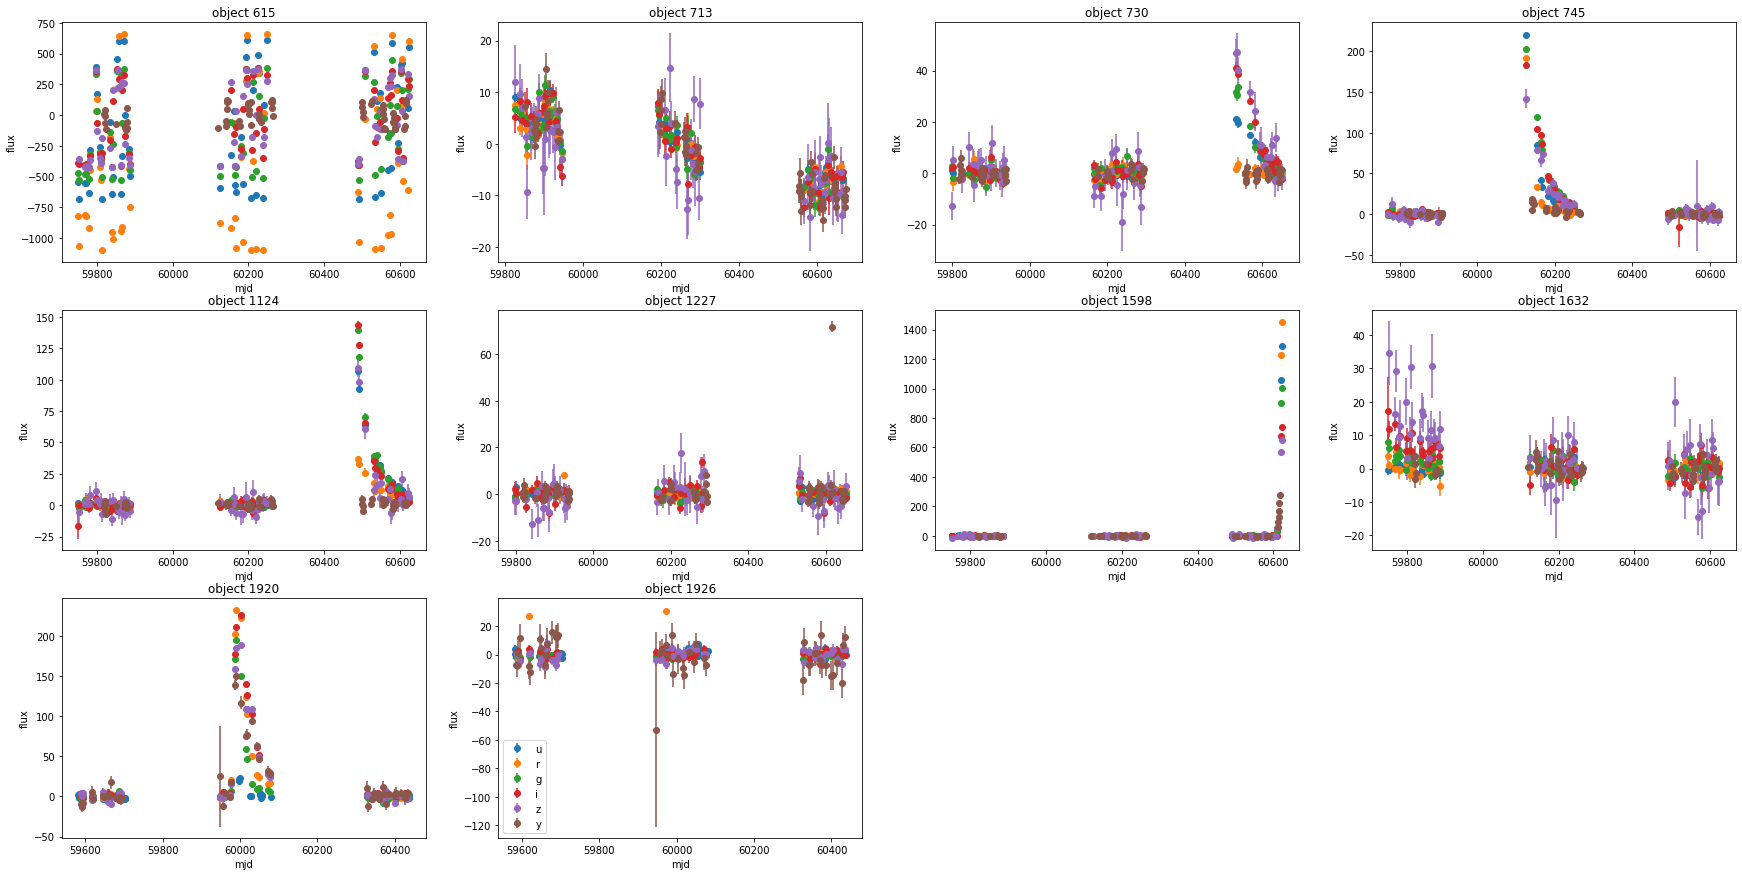

In [ ]:
fig = plt.figure(figsize = (30, 15))
axes = []
for i_plot in range(10):
  axes.append(fig.add_subplot(3, 4, i_plot+1))
  id = plot_objects_id[i_plot]
  mask = lcvs['object_id'] == id
  x = lcvs['mjd'][mask]
  y = lcvs['flux'][mask]
  yerr = lcvs['flux_err'][mask]
  label = lcvs['passband'][mask]

  for f in label.unique():
    label_mask = label == f
    axes[-1].errorbar(x[label_mask], y[label_mask], yerr=yerr[label_mask], fmt='o', label = pbnames[f])
    axes[-1].set_title('object {}'.format(id))
    axes[-1].set_xlabel('mjd')
    axes[-1].set_ylabel('flux')
pl.legend()

Figure shows the light curves for first 10 objects. X axis (time) is mjd, while yaxis is flux. 

From the graph, it seems like the the data is unequal interval timeseries, where the observations are collected mainly at 3 timesteps: around 59600, 60000, and 60400.


Some object timeseries has an outlier, e.g object 1926 has an outlier with huge flux error. There are also sharp peak value in some time series e.g object 1920, 730, 745, 1598

<font color="red"> FBB very ok</font>

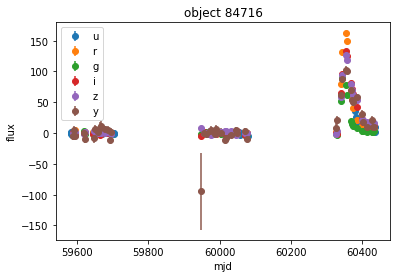

In [ ]:
id = 84716
mask = lcvs['object_id'] == id
x = lcvs['mjd'][mask]
y = lcvs['flux'][mask]
yerr = lcvs['flux_err'][mask]
label = lcvs['passband'][mask]

for f in label.unique():
  label_mask = label == f
  # print(np.mean(y[label_mask]))
  # print(np.sum(label_mask))
  pl.errorbar(x[label_mask], y[label_mask], yerr=yerr[label_mask], fmt='o', label = pbnames[f])
  pl.title('object {}'.format(id))
  pl.xlabel('mjd')
  pl.ylabel('flux')
pl.legend()

light curves of object 84716

<font color="red"> FBB so what do you notice? there is an outlier with large uncertaint, its supposr to raise your awareness about potenital issues w using min max or range as a feature</font>

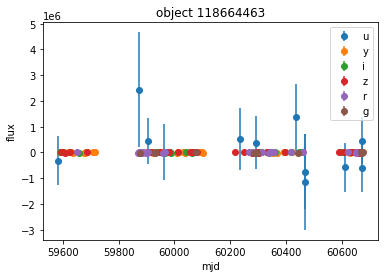

In [ ]:
id = 118664463
mask = lcvs['object_id'] == id
x = lcvs['mjd'][mask]
y = lcvs['flux'][mask]
yerr = lcvs['flux_err'][mask]
label = lcvs['passband'][mask]

for f in label.unique():
  label_mask = label == f
  # print(np.mean(y[label_mask]))
  # print(np.sum(label_mask))
  pl.errorbar(x[label_mask], y[label_mask], yerr=yerr[label_mask], fmt='o', label = pbnames[f])
  pl.title('object {}'.format(id))
  pl.xlabel('mjd')
  pl.ylabel('flux')
pl.legend()

This object 118664463 is an outlier. It has a huge flux value in passband 0 (u) which hurt the distogram in the later part.

<font color="red"> FBB very good</font>

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve - 


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

#my chosen features are: mean, stardard deviation, slope and standard error of line fit and decl.

Mean, standard deviation: From the plots above, different object has clearly different mean flux. So they are useful to tell which object.

slope, standarderror : whithin same object, each passband timeseries are quite linear. bUt the outlier may hurt the slope, so I use standarderror also


decl, ddf_bool: I have no domain knowledge, so I picked this one because the description says this is important

all features are continuous values except ddf_bool which is binary

In [ ]:
#example (you can use this code but this wont count for your 4 features)
group_data = lcvs.groupby(["object_id", "passband"])[['flux']]
stds = group_data.std()
means = group_data.mean()
print(stds.shape)
print(means.shape)

(47088, 1)
(47088, 1)


In [ ]:
group_flux_data = lcvs.groupby(["object_id", "passband"])[['flux']]
flux = lcvs.groupby(["object_id", "passband"])['flux'].apply(list).to_dict()
mjd = lcvs.groupby(["object_id", "passband"])['mjd'].apply(list).to_dict()


In [ ]:
from scipy import stats
from tqdm.notebook import tqdm
standardized_flux = {}
slopes , std_errs = {}, {}
means, stds = {}, {}
keys = list(flux.keys())
for i in tqdm(range(len(keys))):
  key = keys[i]
  means[key] = np.array(flux[key]).mean()
  stds[key] = np.array(flux[key]).std()
  
  standardized_flux[key] = (np.array(flux[key]) - means[key])/stds[key]
  slope, _, _, _, std_err = stats.linregress(mjd[key], standardized_flux[key])
  slopes[key] = slope
  std_errs[key] = std_err

  0%|          | 0/47088 [00:00<?, ?it/s]

In [ ]:
def meregeFeatures(arr_features):
  features = []
  for (i, feature) in enumerate(arr_features):
    np_feature = np.atleast_2d(list(feature.values())).T
    features.append(list(feature.values()))
  features = np.stack(features, axis = 0)
  return features.T
features = meregeFeatures([means, stds, slopes, std_errs])
features.shape

(47088, 4)

In [ ]:
gr_passband = lcvs.groupby(["object_id", "passband"])['passband'].apply(list).to_dict()
passband = []
for i in tqdm(range(len(keys))):
  key = keys[i]
  passband.append(gr_passband[key][0])

  0%|          | 0/47088 [00:00<?, ?it/s]

In [ ]:
passband = np.array(passband)
datas = []
for (i, label) in enumerate(range(6)):
  passband_mask = passband == label
  datas.append(features[passband_mask])

datas = np.stack(datas, axis = 1)
datas = datas.reshape(datas.shape[0], -1)

In [ ]:
decl = np.atleast_2d(metadata['decl'].to_numpy()).T
ddf = np.atleast_2d(metadata['ddf'].to_numpy()).T
object_id = np.atleast_2d(np.unique(lcvs['object_id'].to_numpy())).T.astype(int)
datas = np.concatenate((datas, decl), axis = -1)
datas = np.concatenate((datas, ddf), axis = -1)
datas = np.concatenate((datas, object_id), axis = -1)

In [ ]:
columns = ["mean", "std", "slope", "std_err"]
column_names = []
for i in range(6):
  for column in columns:
    column_names.append("{}_{}".format(i, column))
column_names.append("decl")
column_names.append("ddf")
column_names.append("object_id")


features = pd.DataFrame(datas, columns = column_names)
features = features.set_index("object_id")

In [ ]:
features.shape

(7848, 26)

In [ ]:
features.head()

,0_mean,0_std,0_slope,0_std_err,1_mean,1_std,1_slope,1_std_err,2_mean,2_std,...,4_mean,4_std,4_slope,4_std_err,5_mean,5_std,5_slope,5_std_err,decl,ddf
object_id,,,,,,,,,,,,,,,,,,,,,
615.0,-3.254554,83.275842,0.000528,0.000461,-385.699911,596.576924,0.000564,0.000419,-134.146566,451.180827,...,-55.954592,289.276965,0.001046,0.000402,-47.449847,292.182295,0.001012,0.000410,-61.943836,1.0
713.0,-2.720398,7.062516,-0.002880,0.000200,-1.019804,5.661101,-0.002824,0.000212,-0.794238,5.718981,...,-0.900262,6.349526,-0.002706,0.000239,-1.794175,7.030448,-0.001996,0.000345,-27.784405,1.0
730.0,-0.048080,1.816127,-0.000122,0.000379,0.141057,1.789767,0.000341,0.000474,2.400870,5.505767,...,4.308728,10.604821,0.001492,0.000426,4.539396,13.201397,0.001271,0.000440,-6.579593,1.0
745.0,1.797523,4.343961,-0.000705,0.000412,5.717394,25.731788,-0.000093,0.000439,9.711532,31.671373,...,13.134436,32.772464,-0.000109,0.000439,10.746138,25.822133,0.000003,0.000444,-45.586655,1.0
1124.0,0.660948,2.341279,0.001244,0.000438,4.634637,8.037329,0.001881,0.000343,10.243968,21.135263,...,9.906102,26.633303,0.001356,0.000385,6.896742,21.245772,0.001120,0.000405,-63.823658,1.0


In [ ]:
print("My feature space is {} features (columns)".format(features.shape[1]))

My feature space is 26 features (columns)


My features data has shape of 7848 x 26, where 7848 is the number of object. 27 features are consists of 24 features are mean, std, slop, std_err of 6 passband and 2 features of decl and ddf

As noticed earlier, there are some outlier in data, so for each feature histogram I have to set min-max range to avoid outlier

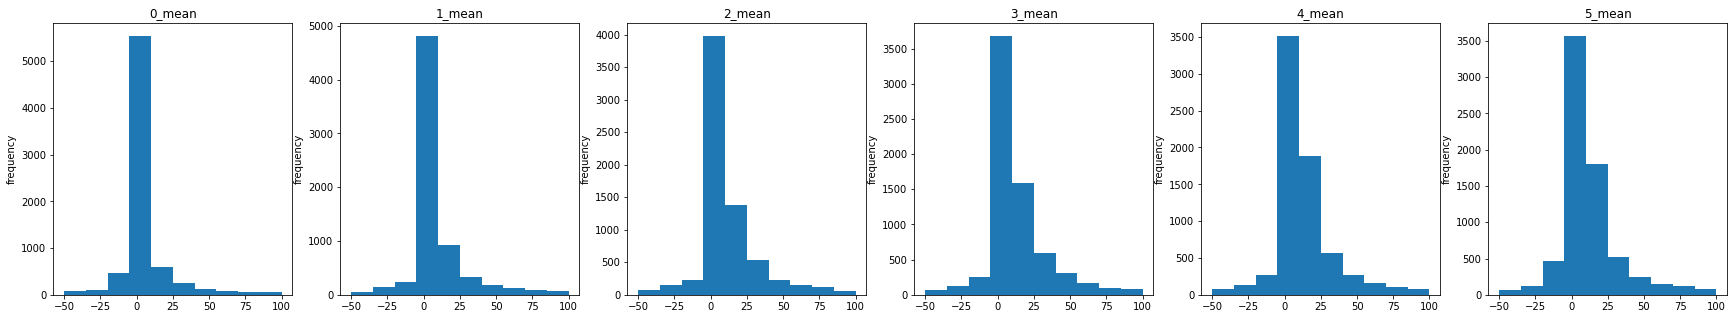

In [ ]:
feature_name = 'mean'
range_hist = (-50, 100)
fig = plt.figure(figsize = (30, 5))
axes = []
for i_plot in range(6):
  column = "{}_{}".format(i_plot, feature_name)
  axes.append(fig.add_subplot(1, 6, i_plot+1))
  axes[-1].hist(features[column].to_numpy(), bins = 10, range = range_hist)
  axes[-1].set_title(column)
  axes[-1].set_ylabel('frequency')

The histogram of mean feature accross 6 passband

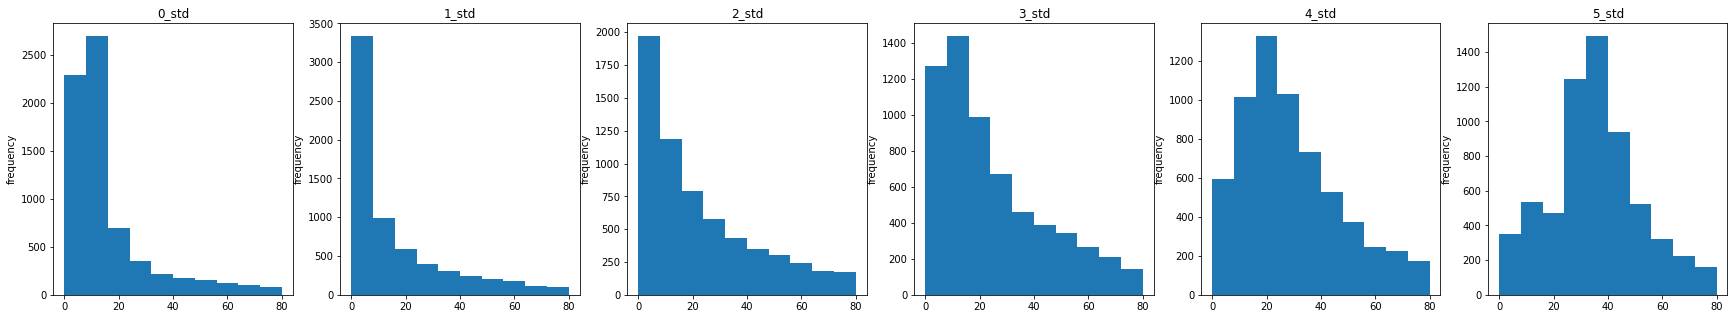

In [ ]:
feature_name = 'std'
range_hist = (0, 80)
fig = plt.figure(figsize = (30, 5))
axes = []
for i_plot in range(6):
  column = "{}_{}".format(i_plot, feature_name)
  axes.append(fig.add_subplot(1, 6, i_plot+1))
  axes[-1].hist(features[column].to_numpy(), bins = 10, range = range_hist)
  axes[-1].set_title(column)
  axes[-1].set_ylabel('frequency')

The histogram of std feature across 6 passband

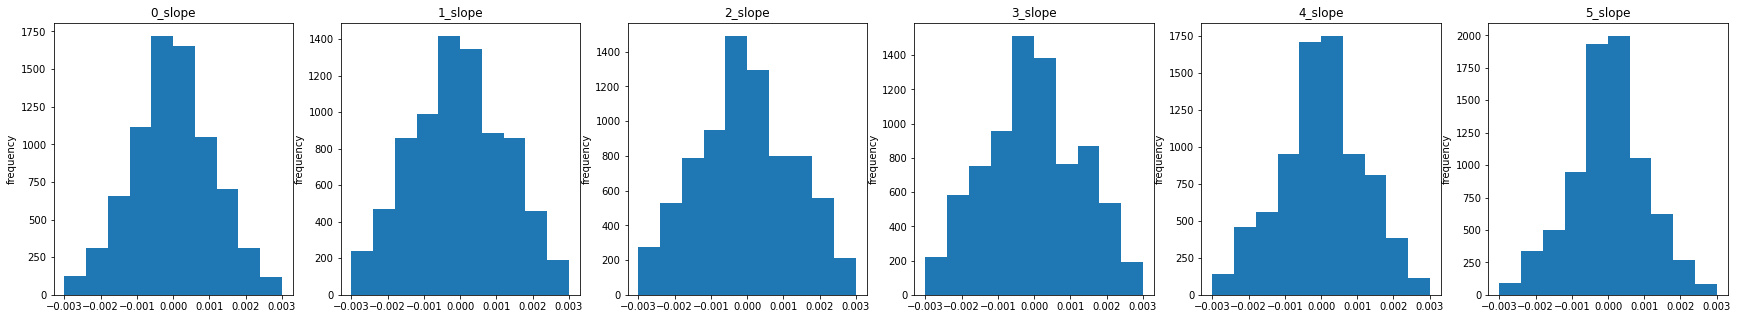

In [ ]:
feature_name = 'slope'
range_hist = (-0.003, 0.003)
fig = plt.figure(figsize = (30, 5))
axes = []
for i_plot in range(6):
  column = "{}_{}".format(i_plot, feature_name)
  axes.append(fig.add_subplot(1, 6, i_plot+1))
  axes[-1].hist(features[column].to_numpy(), bins = 10, range = range_hist)
  axes[-1].set_title(column)
  axes[-1].set_ylabel('frequency')

The histogram of slope feature across 6 passband

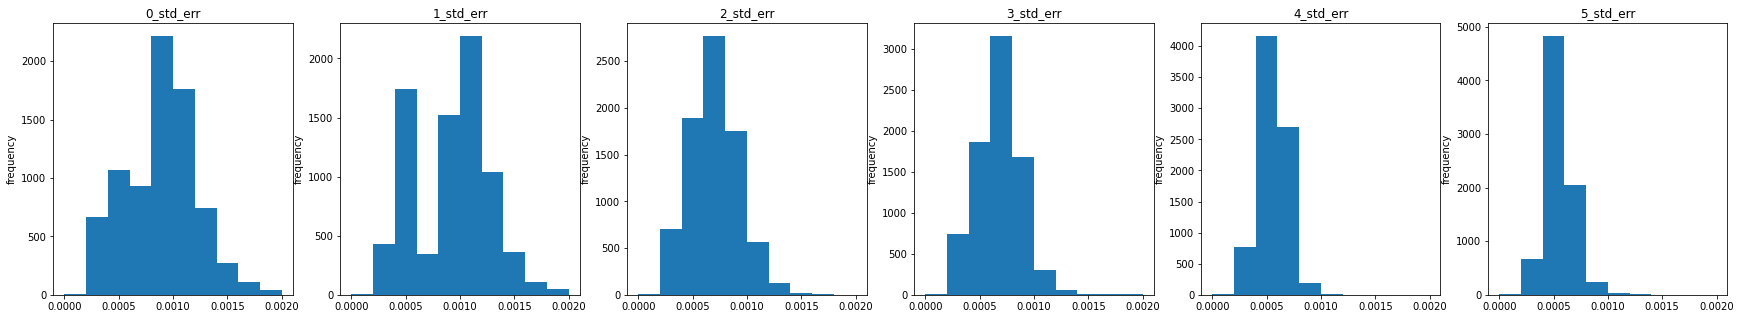

In [ ]:
feature_name = 'std_err'
range_hist = (0, 0.002)
fig = plt.figure(figsize = (30, 5))
axes = []
for i_plot in range(6):
  column = "{}_{}".format(i_plot, feature_name)
  axes.append(fig.add_subplot(1, 6, i_plot+1))
  axes[-1].hist(features[column].to_numpy(), bins = 10, range = range_hist)
  axes[-1].set_title(column)
  axes[-1].set_ylabel('frequency')

The histogram of std_err feature across 6 passband. It seems like the passband 4, 5 are linear

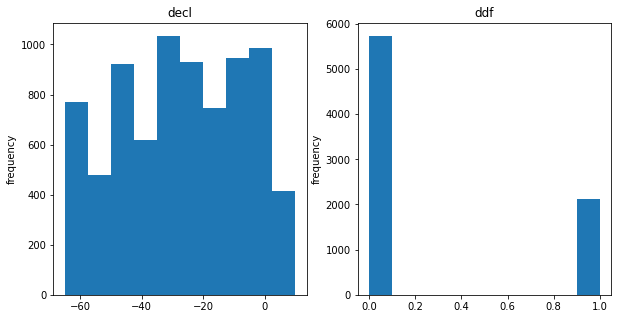

In [ ]:
feature_name = ['decl', 'ddf']
range_hist = [(-65, 10), (0,1)]
fig = plt.figure(figsize = (10, 5))
axes = []
for i_plot in range(2):
  column = feature_name[i_plot]
  axes.append(fig.add_subplot(1, 2, i_plot+1))
  axes[-1].hist(features[column].to_numpy(), bins = 10, range = range_hist[i_plot])
  axes[-1].set_title(column)
  axes[-1].set_ylabel('frequency')

histograms of decl and ddf features

Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


<font color="red"> FBB very good!!</font>

Standardize the lcvs and extract some features from the raw lightcurve - 


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id. 

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

# TASK III : Gaussian Processes

Take the time series and fit them with GPs. 
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab5GP/GP_examples.ipynb)
- make sure you use the standardized time series
- make sure you process the uncertainty as well as the data in the standardization!
- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)
- take a subset of the time series, ~10, making sure that they are of different types
- fit the GP kernerl to each time series band by band
- collect the best fit parameters and describe their variance - can all the time series be fit reasonably with the same kernel? how would you initialize the fit for the whole ensamble?



In [ ]:
!pip install george

     |████████████████████████████████| 407 kB 4.1 MB/s 


In [ ]:
import george
from george import kernels

def fitKernel(id ,f, ax):
  mask = (lcvs['object_id'] == id) & (lcvs['passband'] == f)
  t = lcvs['mjd'][mask]
  y = lcvs['flux'][mask]
  yerr = lcvs['flux_err'][mask]
  t_pred = np.linspace(t.min(), t.max(), 10)

  yerr = (yerr- y.mean())/y.std()
  y = (y - y.mean())/y.std()
  kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(.25), kernels.CosineKernel(2))
  gp = george.GP(kernel)
  gp.compute(t, 0.1*np.abs(y)) # fit without errors

  pred, pred_var = gp.predict(y, t_pred, return_var=True)

  ax.fill_between(t_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                  color="k", alpha=0.2)
  ax.plot(t_pred.ravel(), pred, "k", lw=1.5, alpha=0.5)
  ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
  ax.set_xlabel("x")
  ax.set_ylabel("y");
  ax.set_title("obj {}, passband {}".format(id, f))  

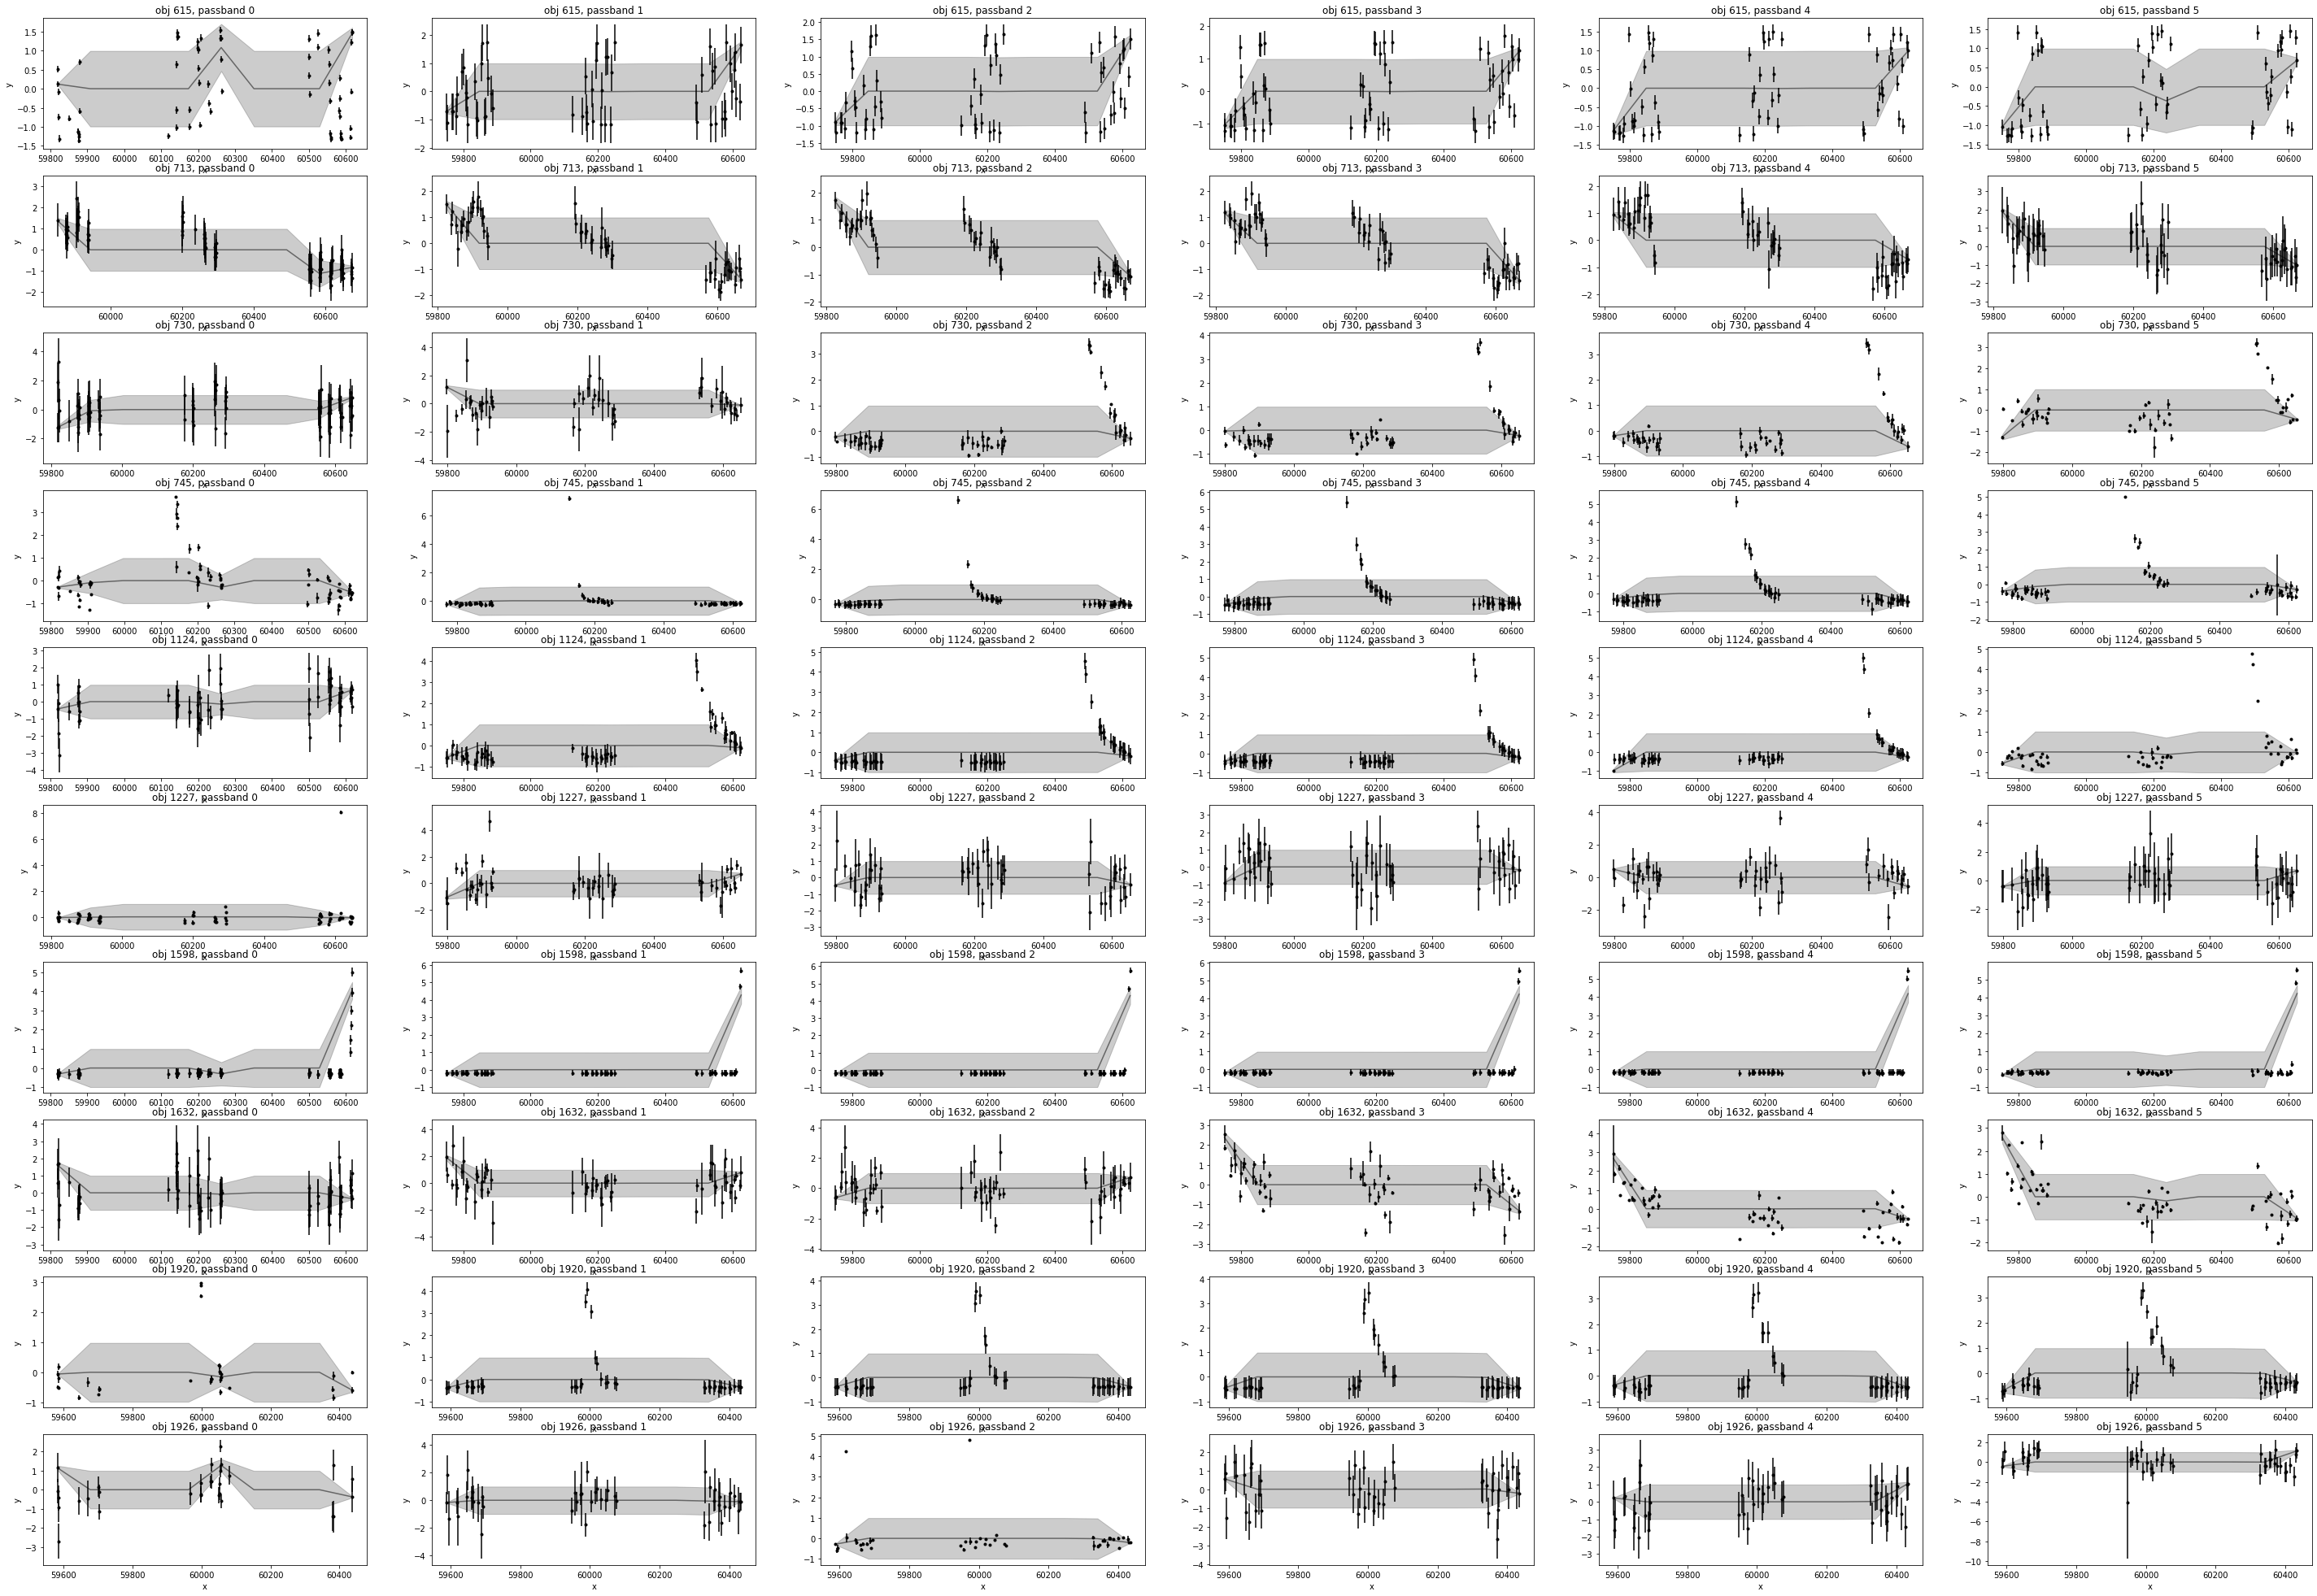

In [ ]:
objs = range(10)
fig = plt.figure(figsize = (50, 35))
axes = []
for index in range(10):
  id = object_id[index][0]
  for f in range(6):
    axes.append(fig.add_subplot(10, 6, index*6 +f + 1))
    fitKernel(id, f, axes[-1])

Gassian process on 10 different objects, band by band. I'm not sure how to improve the performace

<font color="red"> FBB very good optimizing the parameter fir the data is how you would improve this, but you did good altogether

# CHALLENGE (Extra Credit): fit the 2D time series: 
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series. 
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)